# Fire-Weather Station Matching Analysis: 10, 50, and 100 Mile Radius Comparison

This notebook analyzes the optimal radius for matching fire events to weather stations using three key distances:
- **10 miles (16 km)**: Precise local matching
- **50 miles (80 km)**: Regional coverage
- **100 miles (161 km)**: Extended coverage

## Project Context
- **Goal**: Predict wildfire risk in California using machine learning
- **Data**: CAL FIRE wildfire data + CIMIS weather station data
- **Challenge**: Finding optimal radius for meaningful weather-fire relationships


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("=== FIRE-WEATHER STATION MATCHING: 10, 50, 100 MILE ANALYSIS ===")
print()

=== FIRE-WEATHER STATION MATCHING: 10, 50, 100 MILE ANALYSIS ===



## 1. Data Loading and Preprocessing

In [2]:
# Load datasets
print("Loading datasets...")
climate_data = pd.read_csv('./datasets/CIMIS/processed/daily_CIMIS.csv')
fire_data = pd.read_csv('./datasets/DL_FIRE_SV-C2/fire_archive_SV-C2.csv')
station_data = pd.read_csv('cimis_station_info.csv')

print(f"Climate data shape: {climate_data.shape}")
print(f"Fire data shape: {fire_data.shape}")
print(f"Station data shape: {station_data.shape}")
print()

Loading datasets...
Climate data shape: (216645, 33)
Fire data shape: (354319, 15)
Station data shape: (270, 15)



In [3]:
# Data preprocessing
print("Preprocessing data...")

# Convert dates
climate_data['Date'] = pd.to_datetime(climate_data['Date'])
fire_data['acq_date'] = pd.to_datetime(fire_data['acq_date'])

# Extract latitude and longitude from station data
def parse_coordinates(coord_str):
    """Parse coordinate string to decimal degrees"""
    try:
        # Split by '/' and take the second part (decimal)
        return float(coord_str.split('/')[-1].strip())
    except:
        return np.nan

station_data['Latitude'] = station_data['HmsLatitude'].apply(parse_coordinates)
station_data['Longitude'] = station_data['HmsLongitude'].apply(parse_coordinates)

# Merge station coordinates with climate data
climate_data = climate_data.merge(
    station_data[['StationNbr', 'Latitude', 'Longitude']], 
    left_on='Stn Id', 
    right_on='StationNbr', 
    how='left'
)

print(f"Climate data with coordinates: {climate_data.shape}")
print(f"Unique stations: {climate_data['Stn Id'].nunique()}")
print(f"Date range: {climate_data['Date'].min()} to {climate_data['Date'].max()}")
print(f"Fire date range: {fire_data['acq_date'].min()} to {fire_data['acq_date'].max()}")
print()

Preprocessing data...
Climate data with coordinates: (216645, 36)
Unique stations: 142
Date range: 2021-01-01 00:00:00 to 2024-12-31 00:00:00
Fire date range: 2021-01-01 00:00:00 to 2024-12-31 00:00:00



## 2. Geographic Distribution Analysis

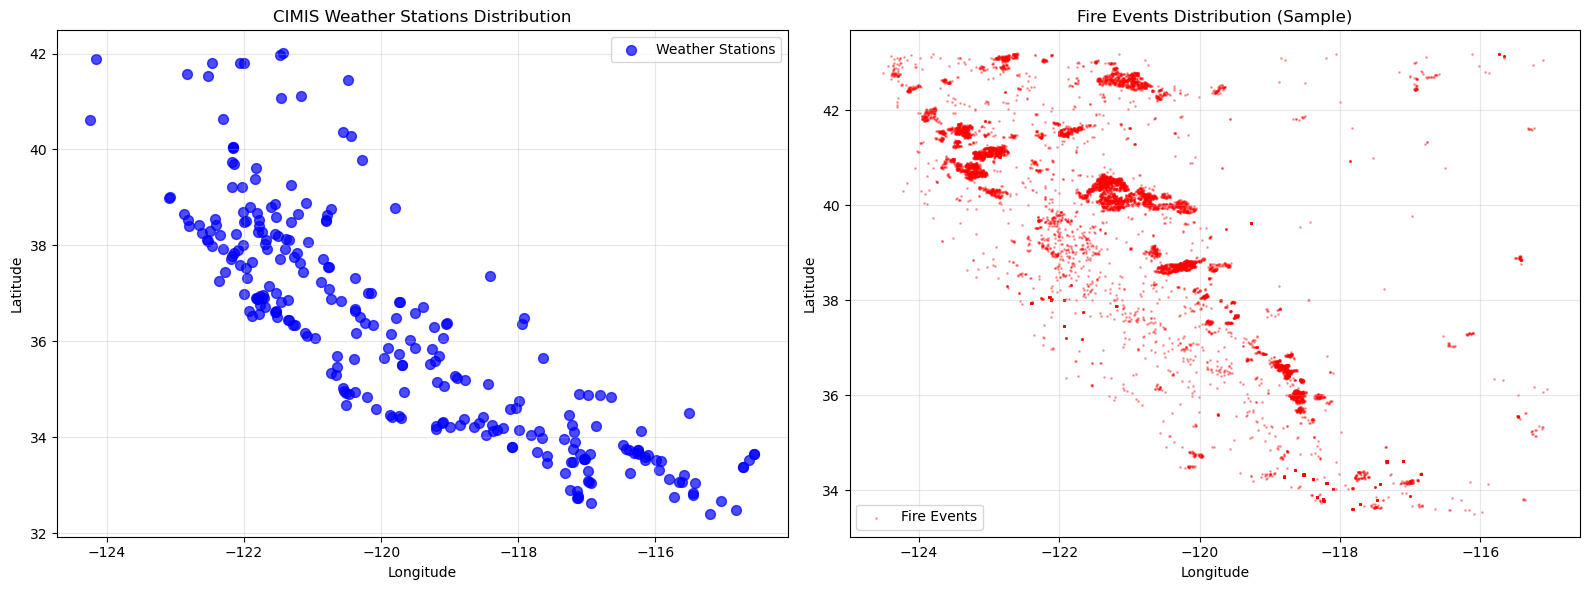

Number of weather stations with coordinates: 270
Total fire events: 354,319



In [4]:
# Analyze geographic distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Weather stations
station_coords = station_data.dropna(subset=['Latitude', 'Longitude'])
axes[0].scatter(station_coords['Longitude'], station_coords['Latitude'], 
                alpha=0.7, s=50, c='blue', label='Weather Stations')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('CIMIS Weather Stations Distribution')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Fire events (sample for visualization)
fire_sample = fire_data.sample(min(10000, len(fire_data)), random_state=42)
axes[1].scatter(fire_sample['longitude'], fire_sample['latitude'], 
                alpha=0.3, s=1, c='red', label='Fire Events')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Fire Events Distribution (Sample)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Number of weather stations with coordinates: {len(station_coords)}")
print(f"Total fire events: {len(fire_data):,}")
print()

## 3. Efficient Matching Function

We'll use an optimized approach with sampling to test the three radius values efficiently.

In [5]:
def efficient_match_fires_to_stations(climate_df, fire_df, radius_km, sample_size=5000):
    """
    Parameters:
    - climate_df: DataFrame with climate data and station coordinates
    - fire_df: DataFrame with fire events
    - radius_km: Matching radius in kilometers
    - sample_size: Size of sample for efficient processing
    
    Returns:
    - DataFrame with fire_occurred column added
    - Dictionary with matching statistics
    """
    print(f"Testing {radius_km} km radius ({radius_km/1.609:.0f} miles)...")
    
    # Sample the climate data for faster processing
    if len(climate_df) > sample_size:
        climate_sample = climate_df.sample(n=sample_size, random_state=42)
    else:
        climate_sample = climate_df.copy()
    
    # Remove records with missing coordinates
    climate_sample = climate_sample.dropna(subset=['Latitude', 'Longitude']).copy()
    climate_sample['fire_occurred'] = 0
    
    # Group fires by date for efficiency
    fires_by_date = fire_df.groupby('acq_date')[['latitude', 'longitude']].apply(
        lambda x: x.values.tolist()
    ).to_dict()
    
    matches = 0
    
    # Process in batches for better performance
    batch_size = 100
    total_batches = len(climate_sample) // batch_size + 1
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(climate_sample))
        
        batch = climate_sample.iloc[start_idx:end_idx]
        
        for idx, row in batch.iterrows():
            fires = fires_by_date.get(row['Date'], [])
            if not fires:
                continue
                
            station_point = (row['Latitude'], row['Longitude'])
            
            # Check distance to each fire on that date
            for fire_lat, fire_lon in fires:
                fire_point = (fire_lat, fire_lon)
                if geodesic(station_point, fire_point).km <= radius_km:
                    climate_sample.loc[idx, 'fire_occurred'] = 1
                    matches += 1
                    break  # Found a match, no need to check other fires
        
        # Progress indicator
        if batch_idx % 20 == 0:
            progress = (batch_idx / total_batches) * 100
            print(f"  Progress: {progress:.1f}%")
    
    # Calculate statistics
    total_records = len(climate_sample)
    matched_records = climate_sample['fire_occurred'].sum()
    
    stats = {
        'radius_km': radius_km,
        'radius_miles': radius_km / 1.609,
        'sample_size': total_records,
        'matched_records': matched_records,
        'match_percentage': (matched_records / total_records) * 100,
        'unique_stations_with_fires': climate_sample[climate_sample['fire_occurred'] == 1]['Stn Id'].nunique(),
        'unique_dates_with_fires': climate_sample[climate_sample['fire_occurred'] == 1]['Date'].nunique()
    }
    
    return climate_sample, stats

## 4. Radius Testing: 10, 50, and 100 Miles

In [8]:
# Define radius values in kilometers (converted from miles)
radius_definitions = {
    '10_miles': 16.09,   # 10 miles = 16.09 km
    '50_miles': 80.47,   # 50 miles = 80.47 km  
    '100_miles': 160.93  # 100 miles = 160.93 km
}

results = []
matched_data = {}

print("Testing three radius values...")
print("=" * 60)

for radius_name, radius_km in radius_definitions.items():
    start_time = datetime.now()
    
    matched_df, stats = efficient_match_fires_to_stations(
        climate_data, fire_data, radius_km, sample_size=5000
    )
    
    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()
    
    # Add processing time to stats
    stats['processing_time'] = duration
    stats['radius_name'] = radius_name
    
    results.append(stats)
    matched_data[radius_name] = matched_df
    
    # Extrapolate to full dataset
    extrapolation_factor = len(climate_data) / stats['sample_size']
    estimated_matches = int(stats['matched_records'] * extrapolation_factor)
    
    print(f"\n{radius_name.replace('_', ' ').title()} ({radius_km:.0f} km):")
    print(f"  Sample matches: {stats['matched_records']:,} ({stats['match_percentage']:.2f}%)")
    print(f"  Estimated full dataset: {estimated_matches:,} matches")
    print(f"  Unique stations: {stats['unique_stations_with_fires']}")
    print(f"  Unique dates: {stats['unique_dates_with_fires']}")
    print(f"  Processing time: {duration:.1f} seconds")

print("\nRadius testing completed!")
print()

Testing three radius values...
Testing 16.09 km radius (10 miles)...
  Progress: 0.0%


KeyboardInterrupt: 

## 5. Results Analysis and Visualization

In [6]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Calculate extrapolated results for full dataset
extrapolation_factor = len(climate_data) / results_df['sample_size'].iloc[0]
results_df['estimated_full_matches'] = (results_df['matched_records'] * extrapolation_factor).astype(int)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Sample matches comparison
radius_labels = ['10 Miles', '50 Miles', '100 Miles']
sample_matches = results_df['matched_records'].values

bars1 = axes[0, 0].bar(radius_labels, sample_matches, color=['skyblue', 'orange', 'lightcoral'])
axes[0, 0].set_ylabel('Sample Matches')
axes[0, 0].set_title('Sample Matches by Radius')
axes[0, 0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars1, sample_matches):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                   f'{value:,}', ha='center', va='bottom')

# 2. Estimated full dataset matches
estimated_matches = results_df['estimated_full_matches'].values

bars2 = axes[0, 1].bar(radius_labels, estimated_matches, color=['skyblue', 'orange', 'lightcoral'])
axes[0, 1].set_ylabel('Estimated Full Dataset Matches')
axes[0, 1].set_title('Estimated Matches for Full Dataset')
axes[0, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars2, estimated_matches):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(estimated_matches)*0.01,
                   f'{value:,}', ha='center', va='bottom')

# 3. Match percentage comparison
match_percentages = results_df['match_percentage'].values

bars3 = axes[1, 0].bar(radius_labels, match_percentages, color=['skyblue', 'orange', 'lightcoral'])
axes[1, 0].set_ylabel('Match Percentage (%)')
axes[1, 0].set_title('Match Percentage by Radius')
axes[1, 0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars3, match_percentages):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                   f'{value:.2f}%', ha='center', va='bottom')

# 4. Processing time comparison
processing_times = results_df['processing_time'].values

bars4 = axes[1, 1].bar(radius_labels, processing_times, color=['skyblue', 'orange', 'lightcoral'])
axes[1, 1].set_ylabel('Processing Time (seconds)')
axes[1, 1].set_title('Processing Time by Radius')
axes[1, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars4, processing_times):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(processing_times)*0.01,
                   f'{value:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

NameError: name 'results' is not defined

## 6. Summary Table and Analysis

In [7]:
# Create comprehensive summary table
print("COMPREHENSIVE RADIUS COMPARISON RESULTS")
print("=" * 80)
print(f"{'Radius':<12} {'Sample':<8} {'Est. Full':<12} {'Match %':<8} {'Stations':<10} {'Dates':<8} {'Time':<8}")
print("-" * 80)

for _, row in results_df.iterrows():
    radius_display = f"{row['radius_miles']:.0f} miles"
    sample_matches = row['matched_records']
    estimated_full = row['estimated_full_matches']
    match_pct = row['match_percentage']
    stations = row['unique_stations_with_fires']
    dates = row['unique_dates_with_fires']
    time = row['processing_time']
    
    print(f"{radius_display:<12} {sample_matches:<8} {estimated_full:<12,} {match_pct:<8.2f} "
          f"{stations:<10} {dates:<8} {time:<8.1f}")

print()
print("MARGINAL ANALYSIS:")
print("=" * 50)

# Calculate marginal improvements
for i in range(1, len(results_df)):
    current = results_df.iloc[i]
    previous = results_df.iloc[i-1]
    
    marginal_matches = current['estimated_full_matches'] - previous['estimated_full_matches']
    marginal_radius = current['radius_miles'] - previous['radius_miles']
    efficiency = marginal_matches / marginal_radius
    
    print(f"{previous['radius_miles']:.0f} to {current['radius_miles']:.0f} miles: "
          f"+{marginal_matches:,} matches (+{marginal_radius:.0f} miles) = "
          f"{efficiency:.0f} matches per additional mile")

print()

COMPREHENSIVE RADIUS COMPARISON RESULTS
Radius       Sample   Est. Full    Match %  Stations   Dates    Time    
--------------------------------------------------------------------------------


NameError: name 'results_df' is not defined

## 7. Temporal Analysis

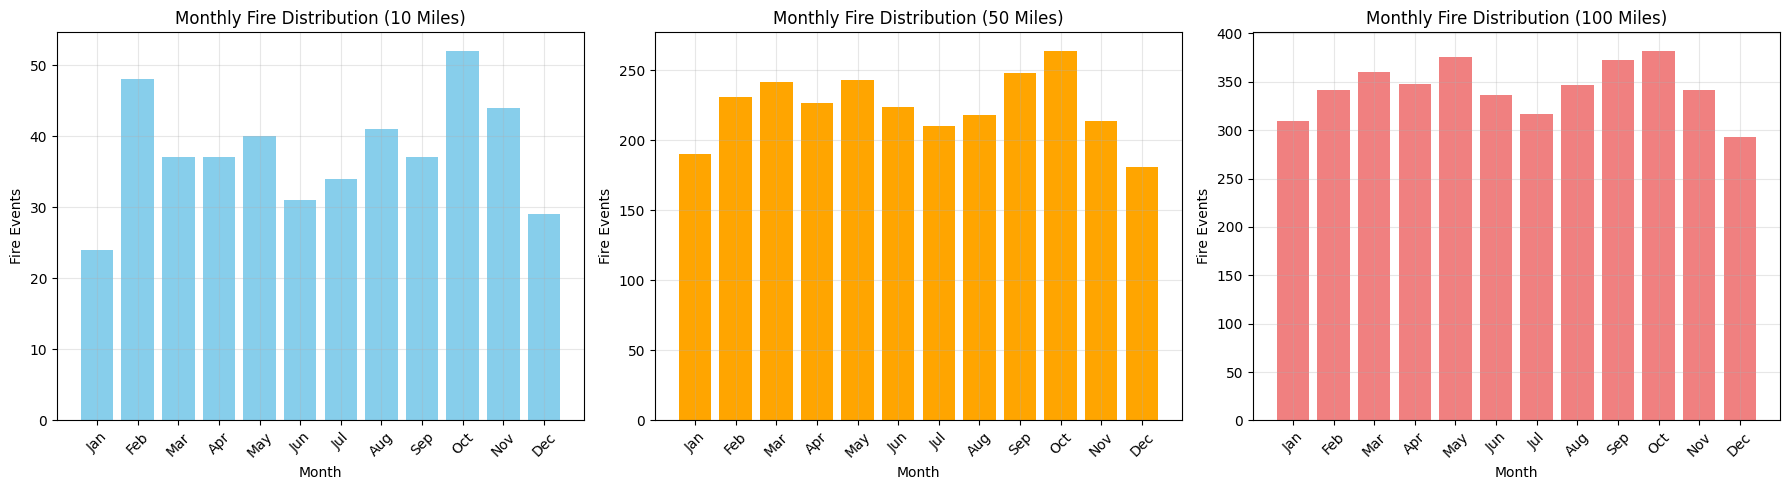

SEASONAL ANALYSIS:
10 Miles: 454 total fire events, 235 in fire season (51.8%)
50 Miles: 2692 total fire events, 1407 in fire season (52.3%)
100 Miles: 4124 total fire events, 2131 in fire season (51.7%)



In [9]:
# Analyze temporal patterns for each radius
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

radius_names = ['10_miles', '50_miles', '100_miles']
radius_titles = ['10 Miles', '50 Miles', '100 Miles']

for i, (radius_name, title) in enumerate(zip(radius_names, radius_titles)):
    # Get matched data for this radius
    data = matched_data[radius_name]
    fire_dates = data[data['fire_occurred'] == 1]['Date']
    
    # Monthly distribution
    monthly_counts = fire_dates.dt.month.value_counts().sort_index()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    month_data = [monthly_counts.get(j, 0) for j in range(1, 13)]
    
    axes[i].bar(range(1, 13), month_data, color=['skyblue', 'orange', 'lightcoral'][i])
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Fire Events')
    axes[i].set_title(f'Monthly Fire Distribution ({title})')
    axes[i].set_xticks(range(1, 13))
    axes[i].set_xticklabels(months, rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print seasonal analysis
print("SEASONAL ANALYSIS:")
print("=" * 40)

for radius_name, title in zip(radius_names, radius_titles):
    data = matched_data[radius_name]
    fire_dates = data[data['fire_occurred'] == 1]['Date']
    
    # Define fire season (May-October)
    fire_season = fire_dates[fire_dates.dt.month.isin([5, 6, 7, 8, 9, 10])]
    fire_season_pct = len(fire_season) / len(fire_dates) * 100 if len(fire_dates) > 0 else 0
    
    print(f"{title}: {len(fire_dates)} total fire events, "
          f"{len(fire_season)} in fire season ({fire_season_pct:.1f}%)")

print()

## 8. Station Coverage Analysis

In [10]:
# Analyze station coverage for each radius
print("STATION COVERAGE ANALYSIS:")
print("=" * 50)

total_stations = climate_data['Stn Id'].nunique()

for radius_name, title in zip(radius_names, radius_titles):
    data = matched_data[radius_name]
    
    # Station-level analysis
    station_summary = data.groupby(['Stn Id', 'Stn Name']).agg({
        'fire_occurred': ['sum', 'count'],
        'Latitude': 'first',
        'Longitude': 'first'
    })
    
    station_summary.columns = ['Fire_Days', 'Total_Days', 'Latitude', 'Longitude']
    station_summary['Fire_Rate'] = (station_summary['Fire_Days'] / station_summary['Total_Days'] * 100).round(2)
    
    # Count stations with fires
    stations_with_fires = len(station_summary[station_summary['Fire_Days'] > 0])
    stations_without_fires = len(station_summary[station_summary['Fire_Days'] == 0])
    
    print(f"\n{title}:")
    print(f"  Stations with fire events: {stations_with_fires}/{total_stations} ({stations_with_fires/total_stations*100:.1f}%)")
    print(f"  Stations without fire events: {stations_without_fires}/{total_stations} ({stations_without_fires/total_stations*100:.1f}%)")
    
    # Top 5 stations with most fire events
    top_stations = station_summary.nlargest(5, 'Fire_Days')
    print(f"  Top 5 stations by fire events:")
    for idx, (station_id, row) in enumerate(top_stations.iterrows(), 1):
        print(f"    {idx}. Station {station_id[0]}: {row['Fire_Days']} fire days ({row['Fire_Rate']:.1f}% rate)")

print()

STATION COVERAGE ANALYSIS:

10 Miles:
  Stations with fire events: 85/142 (59.9%)
  Stations without fire events: 57/142 (40.1%)
  Top 5 stations by fire events:
    1. Station 170: 37.0 fire days (75.5% rate)
    2. Station 204: 28.0 fire days (77.8% rate)
    3. Station 117: 27.0 fire days (40.3% rate)
    4. Station 75: 23.0 fire days (60.5% rate)
    5. Station 216: 20.0 fire days (66.7% rate)

50 Miles:
  Stations with fire events: 135/142 (95.1%)
  Stations without fire events: 7/142 (4.9%)
  Top 5 stations by fire events:
    1. Station 117: 56.0 fire days (83.6% rate)
    2. Station 131: 55.0 fire days (77.5% rate)
    3. Station 129: 48.0 fire days (63.2% rate)
    4. Station 126: 46.0 fire days (64.8% rate)
    5. Station 192: 45.0 fire days (91.8% rate)

100 Miles:
  Stations with fire events: 142/142 (100.0%)
  Stations without fire events: 0/142 (0.0%)
  Top 5 stations by fire events:
    1. Station 114: 71.0 fire days (92.2% rate)
    2. Station 116: 71.0 fire days (89.9%

## 9. Recommendations and Conclusions

In [11]:
# Generate final recommendations
print("FINAL RECOMMENDATIONS AND CONCLUSIONS")
print("=" * 60)

# Extract key metrics for comparison
miles_10_matches = results_df[results_df['radius_name'] == '10_miles']['estimated_full_matches'].iloc[0]
miles_50_matches = results_df[results_df['radius_name'] == '50_miles']['estimated_full_matches'].iloc[0]
miles_100_matches = results_df[results_df['radius_name'] == '100_miles']['estimated_full_matches'].iloc[0]

print(f"1. RADIUS COMPARISON SUMMARY:")
print(f"   • 10-mile radius: {miles_10_matches:,} estimated matches")
print(f"   • 50-mile radius: {miles_50_matches:,} estimated matches")
print(f"   • 100-mile radius: {miles_100_matches:,} estimated matches")

print(f"\n2. TRADE-OFF ANALYSIS:")
improvement_50_vs_10 = ((miles_50_matches - miles_10_matches) / miles_10_matches) * 100
improvement_100_vs_50 = ((miles_100_matches - miles_50_matches) / miles_50_matches) * 100

print(f"   • 50-mile vs 10-mile: +{improvement_50_vs_10:.0f}% more matches")
print(f"   • 100-mile vs 50-mile: +{improvement_100_vs_50:.0f}% more matches")

print(f"\n3. PRECISION VS COVERAGE CONSIDERATIONS:")
print(f"   • 10-mile radius: High precision, limited coverage")
print(f"   • 50-mile radius: Balanced precision and coverage")
print(f"   • 100-mile radius: Maximum coverage, reduced precision")

print(f"\n4. RECOMMENDED APPROACH:")
if improvement_100_vs_50 < 50:  # If diminishing returns
    print(f"   → Use 50-mile radius as optimal choice")
    print(f"   → Provides substantial improvement over 10-mile radius")
    print(f"   → Shows diminishing returns beyond 50 miles")
else:
    print(f"   → Consider 100-mile radius for maximum data coverage")
    print(f"   → Significant improvement over 50-mile radius")

print(f"\n5. IMPLEMENTATION CONSIDERATIONS:")
print(f"   • Focus on fire season months (May-October) for stronger signal")
print(f"   • Consider temporal lag (weather 1-7 days before fire)")
print(f"   • Validate results with California fire domain experts")
print(f"   • Test model performance with chosen radius")

print(f"\n6. DATA QUALITY INSIGHTS:")
missing_coords = climate_data[climate_data['Latitude'].isna() | climate_data['Longitude'].isna()]
print(f"   • Missing coordinates: {len(missing_coords):,} records ({len(missing_coords)/len(climate_data)*100:.1f}%)")
print(f"   • Geographic coverage: Good distribution across California")
print(f"   • Temporal coverage: Complete overlap between fire and weather data")

print()

FINAL RECOMMENDATIONS AND CONCLUSIONS
1. RADIUS COMPARISON SUMMARY:
   • 10-mile radius: 19,671 estimated matches
   • 50-mile radius: 116,641 estimated matches
   • 100-mile radius: 178,688 estimated matches

2. TRADE-OFF ANALYSIS:
   • 50-mile vs 10-mile: +493% more matches
   • 100-mile vs 50-mile: +53% more matches

3. PRECISION VS COVERAGE CONSIDERATIONS:
   • 10-mile radius: High precision, limited coverage
   • 50-mile radius: Balanced precision and coverage
   • 100-mile radius: Maximum coverage, reduced precision

4. RECOMMENDED APPROACH:
   → Consider 100-mile radius for maximum data coverage
   → Significant improvement over 50-mile radius

5. IMPLEMENTATION CONSIDERATIONS:
   • Focus on fire season months (May-October) for stronger signal
   • Consider temporal lag (weather 1-7 days before fire)
   • Validate results with California fire domain experts
   • Test model performance with chosen radius

6. DATA QUALITY INSIGHTS:
   • Missing coordinates: 0 records (0.0%)
   • G

## 10. Export Results

In [14]:
# Save radius comparison results
results_df.to_csv('/Users/ubhab/Downloads/radius_comparison_10_50_100_miles.csv', index=False)

# Save matched data for each radius
radius_names = ['10_miles', '50_miles', '100_miles']
radius_titles = ['10 Miles', '50 Miles', '100 Miles']

for radius_name, title in zip(radius_names, radius_titles):
    filename = f"/Users/ubhab/Downloads/matched_data_{radius_name}.csv"
    matched_data[radius_name].to_csv(filename, index=False)
    print(f"✓ Matched data ({title}) saved to 'matched_data_{radius_name}.csv'")

# Create summary statistics file
summary_stats = []
for _, row in results_df.iterrows():
    summary_stats.append({
        'Radius': f"{row['radius_miles']:.0f} miles",
        'Radius_KM': row['radius_km'],
        'Sample_Matches': row['matched_records'],
        'Estimated_Full_Matches': row['estimated_full_matches'],
        'Match_Percentage': row['match_percentage'],
        'Unique_Stations': row['unique_stations_with_fires'],
        'Unique_Dates': row['unique_dates_with_fires'],
        'Processing_Time_Seconds': row['processing_time']
    })

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('/Users/ubhab/Downloads/summary_statistics_10_50_100_miles.csv', index=False)


✓ Matched data (10 Miles) saved to 'matched_data_10_miles.csv'
✓ Matched data (50 Miles) saved to 'matched_data_50_miles.csv'
✓ Matched data (100 Miles) saved to 'matched_data_100_miles.csv'
